## Anomaly Detection

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import dates as md

In [72]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv')
data.shape

(15831, 2)

In [73]:
data.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text major ticklabel objects>)

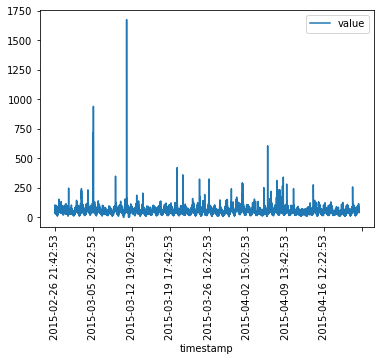

In [74]:
data.set_index('timestamp').plot()
plt.xticks(rotation='vertical')

In [75]:
data.describe()

,value
count,15831.000000
mean,53.298465
std,30.553147
min,0.000000
25%,36.000000
50%,50.000000
75%,65.000000
max,1673.000000


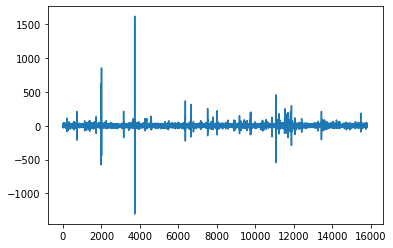

In [76]:
plt.plot(data['value'] - data['value'].shift(1))

In [77]:
np.where(np.array(abs(data['value'] - data['value'].shift(1))) >= 400)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


(array([ 1993,  1994,  2008,  2009,  2010,  3735,  3736, 11070, 11072]),)

11070    486
11071    605
11072     60
11073     37
11074     41
Name: value, dtype: int64


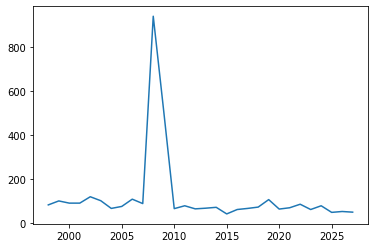

In [78]:
print(data['value'][11070:11075])
plt.plot(data['value'][2008-10:2008+20])

In [79]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):], y[:int(len(y)*0.9)], y[int(len(y)*0.9):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14247, 1), (14247, 1), (1583, 1), (1583, 1))

In [80]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler = scaler.fit(X_train)
# X_train = scaler.transform(X_train)

In [81]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler = scaler.fit(X_val)
# X_val = scaler.transform(X_val)

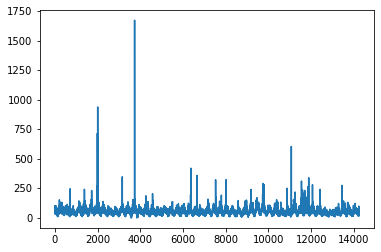

In [82]:
plt.plot(X_train)

In [83]:
# median = np.median(X_train)
# print("before", median)
# X_train[np.where(X_train >= 65)] = 65
# X_train[np.where(X_train <= 36)] = 36
# print("after", np.median(X_train))

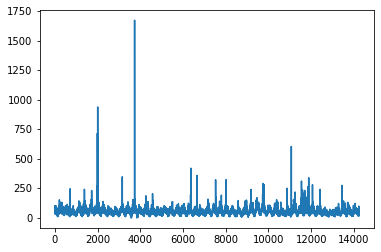

In [84]:
plt.plot(X_train)

In [85]:
n_timesteps = 144
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
k=-5

In [86]:
print([i for i in enumerate(X_train[:500])])

[(0, array([57])), (1, array([43])), (2, array([55])), (3, array([64])), (4, array([93])), (5, array([104])), (6, array([89])), (7, array([87])), (8, array([57])), (9, array([68])), (10, array([64])), (11, array([61])), (12, array([73])), (13, array([79])), (14, array([80])), (15, array([76])), (16, array([49])), (17, array([59])), (18, array([55])), (19, array([48])), (20, array([41])), (21, array([49])), (22, array([63])), (23, array([36])), (24, array([42])), (25, array([50])), (26, array([35])), (27, array([41])), (28, array([39])), (29, array([48])), (30, array([31])), (31, array([35])), (32, array([32])), (33, array([36])), (34, array([37])), (35, array([62])), (36, array([41])), (37, array([51])), (38, array([65])), (39, array([39])), (40, array([56])), (41, array([42])), (42, array([62])), (43, array([46])), (44, array([46])), (45, array([62])), (46, array([41])), (47, array([40])), (48, array([47])), (49, array([48])), (50, array([43])), (51, array([41])), (52, array([55])), (

In [87]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples+1)]
X_train_list = X_train_list[:k]
X_train = np.concatenate(X_train_list, axis=0)
y_train_list = [np.expand_dims(y_train[i:i+5, :], axis=0) for i in range(n_timesteps, n_samples -5 + 1)]
y_train = np.concatenate(y_train_list, axis=0)
X_train = X_train[:-1, :, :]
y_train = y_train[1:, :, :]
# y_train = y_train[n_timesteps-1:, :]


X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val_list = X_val_list[:k]
X_val = np.concatenate(X_val_list, axis=0)
# y_val = y_val[n_timesteps-1:, :]
y_val_list = [np.expand_dims(y_val[i:i+5, :], axis=0) for i in range(n_timesteps, n_val_samples- 5 + 1)]
y_val = np.concatenate(y_val_list, axis=0)
X_val = X_val[:-1, :, :]
y_val = y_val[1:, :, :]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14098, 144, 1), (14098, 5, 1), (1434, 144, 1), (1434, 5, 1))

In [88]:
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
# X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# y_val = y_val.reshape(y_val.shape[0], 1, y_val.shape[1])


In [89]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14098, 144, 1), (14098, 5, 1), (1434, 144, 1), (1434, 5, 1))

In [90]:
#AUTOENCODER

model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
     
        # layers.Conv1D(
        #     filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        # ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # layers.Conv1DTranspose(
        #     filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        # ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

# dimensions = 100
# def AutoencoderLSTM(n_timesteps, n_features):
#     i = Input(shape=(n_timesteps, 1))
     
    
#     x = LSTM(dimensions, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features))(i)
#     x = Dropout(0.2)(x)

#     x = LSTM(int(dimensions/2), activation='relu', return_sequences=True)(x)
#     x = Dropout(0.2)(x)

#     x = LSTM(int(dimensions/2), activation='relu', return_sequences=True)(x)
#     x = LSTM(dimensions, activation='relu', return_sequences=True)(x)

#     output = layers.TimeDistributed(Dense(n_features))(x)
#     model = Model(inputs=i, outputs=output)
#     opt = Adam(lr=0.01)
#     model.compile(loss='mean_absolute_error', optimizer=opt)
    
#     return model
  
# model = AutoencoderLSTM(n_timesteps, 5)
# model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 144, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 72, 32)            256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 72, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 36, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 72, 16)            1808      
_________________________________________________________________
dropout_10 (Dropout)         (None, 72, 16)            0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 144, 32)          

In [91]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")],
)


Epoch 1/50
199/199 [==============================] - 1s 4ms/step - loss: 1116.9742 - val_loss: 274.9308
Epoch 2/50
199/199 [==============================] - 1s 3ms/step - loss: 436.6895 - val_loss: 461.0900
Epoch 3/50
199/199 [==============================] - 1s 3ms/step - loss: 363.6895 - val_loss: 461.7777
Epoch 4/50
199/199 [==============================] - 1s 3ms/step - loss: 314.6561 - val_loss: 384.5523
Epoch 5/50
199/199 [==============================] - 1s 3ms/step - loss: 299.4778 - val_loss: 494.7794
Epoch 6/50
199/199 [==============================] - 1s 3ms/step - loss: 286.2638 - val_loss: 353.6601
Epoch 7/50
199/199 [==============================] - 1s 3ms/step - loss: 267.1895 - val_loss: 370.4095
Epoch 8/50
199/199 [==============================] - 1s 3ms/step - loss: 269.0061 - val_loss: 294.0950
Epoch 9/50
199/199 [==============================] - 1s 3ms/step - loss: 273.5962 - val_loss: 353.1242
Epoch 10/50
199/199 [==============================] - 1s 3ms/s

In [92]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(14098, 144, 1)

In [93]:
len(y_train_pred[1,:])

144

In [94]:
from sklearn.metrics import mean_absolute_error
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
errors = [mean_absolute_error(X_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

14098

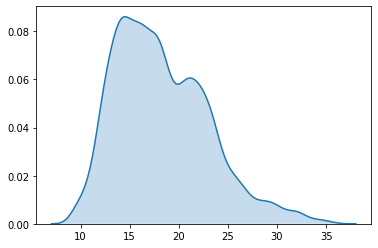

In [95]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

In [96]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(18.285119006257304, 4.757739177957353)

In [97]:
def is_anomaly(error, mean, std, threshold):
    difference = np.abs(error - mean)
    print(difference)
    value = difference / std
    if value < threshold:
        return 0
    else:
        return 1

In [106]:
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
val_errors = [mean_absolute_error(X_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results = [is_anomaly(x, dist.mean(), dist.std(), 1) for x in val_errors]

0.8707272716154186
1.0879824401063587
1.1966535224970372
1.3324654341859485
1.2619320791088384
1.5360247798551647
1.5304332283923543
1.7637543387998669
1.5193289625435575
1.8249171549534964
1.6657881314015555
1.8865609408540394
1.663585474867574
2.0251102157224743
1.9819139879070562
2.1597370281275303
1.8947018492012724
2.130861836121099
2.227652573697057
2.3741906723502133
2.1371117142627156
2.4976400244026884
2.585358299260953
2.7667563333567173
2.4747754707392247
2.875357890240636
3.07319375949994
3.163089988078294
3.0740058396713117
3.178204745828065
3.160336544890157
3.1557850547422497
3.038589077637212
3.1539068196670392
3.149430034007249
3.3423716731657116
3.2676877155359776
3.549746484338197
3.4309170485658314
3.6360338238665975
3.444561902793531
3.7215204213516095
3.7070281745118763
3.8813585150032743
3.822564016559671
4.041849875561681
4.23539768071203
4.2236163060985845
4.258592867962804
4.320194586229608
4.298449964105043
4.281328940503087
4.208771967999425
4.31892458344064

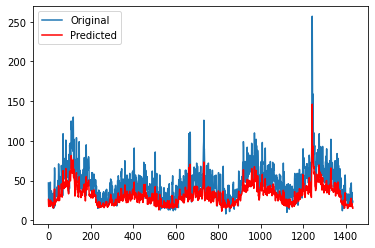

In [107]:
import matplotlib.pyplot as plt

plt.plot(X_val[:,0], label="Original")
plt.plot(y_val_pred[:,0],color="r", label="Predicted")
plt.legend()

In [108]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

In [109]:
# result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]
# print(result)


In [110]:
np.where(np.array(results) == 1)

(array([ 157,  158,  159,  160,  161,  162,  163,  164,  165,  166,  167,
         168,  169,  170,  171,  172,  173,  174,  175,  176,  177,  178,
         179,  180,  181,  182,  183,  184,  185,  186,  187,  188,  189,
         190,  191,  192,  193,  194,  195,  196,  197,  198,  199,  200,
         201,  202,  203,  204,  205,  206,  207,  208,  209,  210,  211,
         212,  213,  214,  215,  216,  217,  218,  219,  220,  221,  222,
         223,  224,  225,  226,  227,  228,  229,  230,  231,  232,  233,
         234,  235,  236,  237,  238,  239,  240,  241,  242,  243,  244,
         245,  246,  247,  248,  249,  250,  251,  252,  253,  254,  255,
         256,  257,  258,  259,  260,  261,  262,  263,  264,  265,  266,
         267,  268,  269,  270,  271,  272,  273,  274,  275,  276,  277,
         278,  279,  280,  281,  282,  283,  284,  285,  286,  287,  288,
         289,  290,  293,  294,  295,  297,  298,  299,  381,  383,  384,
         385,  386,  387,  388,  389, 

In [111]:
plot_x=[]
plot_y=[]
for i in range(len(results)): 
  if results[i] == 1:
    plot_x.append(i)
    plot_y.append(X_val[i][0])
print(plot_x)

[157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 293, 294, 295, 297, 298, 299, 381, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,

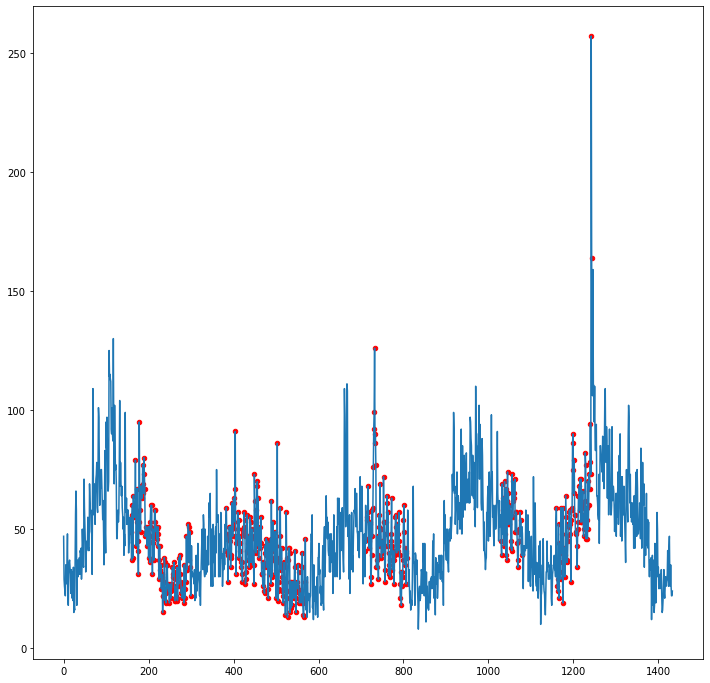

In [112]:
plt.figure(figsize=(12,12))
plt.plot(X_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)


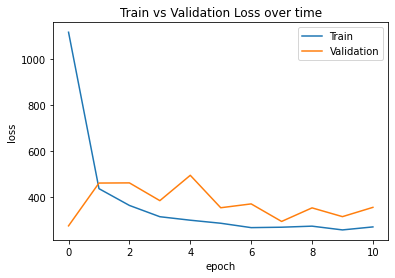

In [114]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='best')